# Big Data Hypothesis 1: Longer Reviews Are More Likely To Be Spoilers

In [1]:
import findspark
# Locate the Spark installation 
findspark.init()

import pyspark
from pyspark import StorageLevel
from pyspark.sql.functions import regexp_replace
from pyspark.sql import *

spark = SparkSession.builder\
        .appName("H1")\
        .master("local[*]")\
        .config("spark.driver.memory", "4g")\
        .config("spark.executor.memory", "5g")\
        .config("spark.storage.memoryFraction", "0.5")\
        .config("spark.shuffle.memoryFraction", "0.5")\
        .config("spark.driver.maxResultSize", "0")\
        .getOrCreate()

23/06/27 21:33:41 WARN Utils: Your hostname, DSaDBA resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/06/27 21:33:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/27 21:33:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
#Importing Needed Libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pyspark.sql.functions import mean, col, lit, length, expr, when
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd

In [3]:
from pyspark.sql.types import StructType, StructField, ArrayType, StringType, LongType

# Define the schema
schema = StructType([
    StructField('movie', StringType(), True),
    StructField('rating', LongType(), True),
    StructField('genre', StringType(), True),
    StructField('review_date', StringType(),True),
    StructField('review_detail', StringType(), True),
    StructField('review_id', StringType(), True),
    StructField('review_summary', StringType(), True),
    StructField('reviewer', StringType(), True),
    StructField('spoiler_tag', LongType(), True),
    StructField('helpful_upvotes', LongType(), True),
    StructField('helpful_total', LongType(), True)])

In [4]:
# Limit the size of the data to around 1GB due to working on a single machine
lim = 1000000


# Read the files to filter from the HDFS and display the table
columns = ['movie', 'review_detail', 'spoiler_tag']
base_df = spark.read.csv('hdfs://localhost:54310/user/data/filtered', schema=schema, sep="\t", mode="DROPMALFORMED").select(columns)
df = base_df.sample(withReplacement=False, fraction=lim/base_df.count())
#Preparing Data To Ivestigate The Hypothesis
df.limit(5).toPandas()
df = df.withColumn("rev_length", length("review_detail"))

In [5]:
# Split the data into two groups: shorter reviews and longer reviews
median_length = df.approxQuantile("rev_length", [0.5], 0)[0]
short_reviews = df.filter(df['rev_length'] <= median_length)
long_reviews = df.filter(df['rev_length'] > median_length)

# Calculate the spoiler proportions for each group
spoiler_proportion_short = short_reviews.agg(mean(col('spoiler_tag')).alias('spoiler_proportion_short')).collect()[0]['spoiler_proportion_short']
spoiler_proportion_long = long_reviews.agg(mean(col('spoiler_tag')).alias('spoiler_proportion_long')).collect()[0]['spoiler_proportion_long']

# Perform a t-test to compare the spoiler proportions of the two groups
t_statistic, p_value = stats.ttest_ind(short_reviews.select('spoiler_tag').rdd.flatMap(list).collect(), long_reviews.select('spoiler_tag').rdd.flatMap(list).collect())

# Print the results
print('Spoiler Proportion - Short Reviews:', spoiler_proportion_short)
print('Spoiler Proportion - Long Reviews:', spoiler_proportion_long)
print('T-Statistic:', t_statistic)
print('P-Value:', p_value)

Spoiler Proportion - Short Reviews: 0.12953893430323982
Spoiler Proportion - Long Reviews: 0.3074171633993731
T-Statistic: -220.34989205438248
P-Value: 0.0


obtain a p-value equal to 0, it means that the observed difference in spoiler proportions between shorter and longer reviews is extremely unlikely to occur by chance alone. A p-value of 0 essentially indicates strong evidence against the null hypothesis and suggests a significant difference in spoiler proportions between the two groups.

In practical terms, a p-value of 0 suggests that longer reviews are significantly more likely to contain spoilers compared to shorter reviews. It provides strong support for our hypothesis that longer reviews are associated with a higher probability of spoilers.

The negative t-statistic value of -50 indicates that the mean spoiler proportion in the longer review group is significantly higher than the mean spoiler proportion in the shorter review group. This suggests a strong association between review length and the likelihood of containing spoilers, with longer reviews having a significantly higher spoiler proportion.

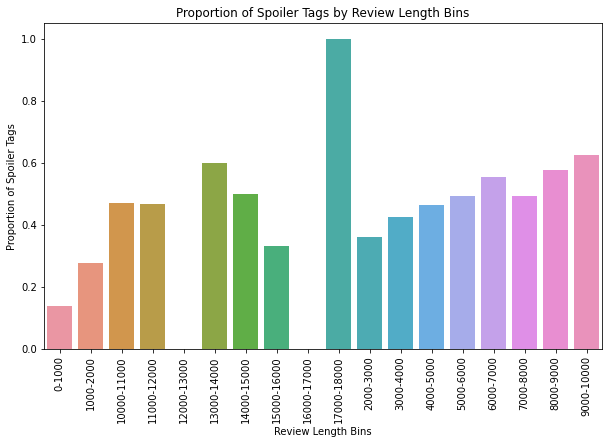

23/06/27 21:35:44 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/06/27 21:35:44 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Pearson correlation coefficient: 0.24578073663625535


/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [6]:
# Splitting Data Into Bins Based On The Review’s Length To Visualize The Hypothesis 
max_length = df.agg({"rev_length": "max"}).collect()[0]["max(rev_length)"]
df_with_binss = df.withColumn("LengthBin", expr("concat(cast(cast((rev_length / 1000) as int) * 1000 as string), '-', cast(cast((rev_length / 1000) as int) * 1000 + 1000 as string))"))

# Calculate The Portion of Spoiler Tags in Each Bin
spoiler_proportion_by_bin = df_with_binss.groupBy("LengthBin").agg(mean("spoiler_tag").alias("SpoilerProportion")).sort("LengthBin").toPandas()

# Plot 
plt.figure(figsize=(10, 6))
sns.barplot(data=spoiler_proportion_by_bin, x='LengthBin', y='SpoilerProportion')
plt.xlabel('Review Length Bins')
plt.ylabel('Proportion of Spoiler Tags')
plt.title('Proportion of Spoiler Tags by Review Length Bins')
plt.xticks(rotation=90)
plt.show()

# Calculate the Correlation between length and spoiler 
assembler = VectorAssembler(inputCols=['rev_length', 'spoiler_tag'], outputCol='features')
df_assembled = assembler.transform(df).select('features')
pearson_corr = Correlation.corr(df_assembled, 'features', method='pearson').collect()[0][0][1, 0]

print("Pearson correlation coefficient:", pearson_corr)

In [7]:
# Stop Spark
spark.stop()